# Analyse comparative des méthodes de classification {CLAIM, REF} vs. {CONTEXT} pour les données scientifiques

Notre jeu de données présente des défis particuliers pour la classification binaire entre {CLAIM, REF} et {CONTEXT}, spécifiquement pour les tweets de la catégorie scientifique. Examinons les trois approches possibles avec leurs avantages et limitations :

## 1. Méthode d'exclusivité stricte

**Principe :** Assigner {CLAIM, REF} = 0 et {CONTEXT} = 1, puis supprimer tous les tweets appartenant simultanément à plusieurs catégories.

**Avantages :**
- Frontière de décision plus nette et classification facilitée
- Modèle théoriquement plus précis sur les cas "purs"

**Limitations :**
- Perte significative de données d'entraînement
- Modèle incapable de traiter correctement les cas ambigus en situation réelle

## 2. Méthode d'attribution par défaut

**Principe :** Définir une classe par défaut pour les tweets multi-étiquettes (soit dans {CLAIM, REF} = 0, soit dans {CONTEXT} = 1).

**Avantages :**
- Conservation de l'intégralité du jeu de données
- Implémentation simple et directe
- Meilleure couverture des cas réels

**Limitations :**
- Introduction d'un biais systémique selon la classe par défaut choisie
- Représentation inexacte de la réalité linguistique des tweets
- Risque d'apprendre des motifs incorrects pour la classification

## 3. Méthode de classification multi-étiquettes

**Principe :** Créer des catégories distinctes pour représenter toutes les combinaisons possibles ({CONTEXT}, {CLAIM, REF}, {CLAIM, REF, CONTEXT}).

**Avantages :**
- Représentation fidèle de la complexité réelle des données
- Préservation des nuances linguistiques et structurelles
- Possibilité d'analyses plus fines des caractéristiques de chaque combinaison

**Limitations :**
- Complexité accrue du modèle de classification
- Risque de dispersion des données entre trop de classes
- Nécessité d'un volume de données plus important pour chaque sous-catégorie

In [88]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from nltk.tokenize import TweetTokenizer
import re


from scipy.stats import kruskal

In [11]:
df_path= "../../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype("string")

### On filtre seulement les tweets sciences related

In [12]:
df_base = df_base[df_base["science_related"] == 1]
df_base.head()

,text,science_related,scientific_claim,scientific_reference,scientific_context
2,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0
6,“Traffic Jam” In Brain’s Neurons Could Be Caus...,1,1.0,1.0,1.0
7,Can playing more games improve lives and save ...,1,1.0,0.0,0.0


In [20]:
classe = {
	(1,0) : 0,
	(0,1) : 1,
	(1,1) : 2,
}

df = df_base.copy()
df["claim_ref"] = df["scientific_claim"].combine_first(df["scientific_reference"]).astype(int)
df["scientific_context"] = df["scientific_context"].astype(int)
df["classe"] = df.apply(lambda row: classe.get((row["claim_ref"], row["scientific_context"]), None), axis=1)

In [21]:
df = df.drop(["science_related","scientific_claim","scientific_reference"], axis=1)
df.head(10)

,text,scientific_context,claim_ref,classe
2,Can any Gynecologist with Cancer Experience ex...,0,1,0
3,Couch-lock highs lead to sleeping in the couch...,0,1,0
4,Does daily routine help prevent problems with ...,0,1,0
6,“Traffic Jam” In Brain’s Neurons Could Be Caus...,1,1,2
7,Can playing more games improve lives and save ...,0,1,0
8,The effect of climate change on iceberg produc...,1,0,1
14,@RepCohen @SenAlexander @SenBobCorker pls supp...,1,0,1
15,Poverty is the greatest cause behind child lab...,0,1,0
16,"""@TheFactsBook: Drinking chocolate milk has be...",0,1,0
24,"A wise Physician said, “The best medicine for ...",0,1,0


# Analyse général de la structure du dataset

In [36]:

# Display basic information about the dataset
print(f"Dataset dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nDataset information:\n")
print(df.info())

print("\nSummary statistics:")
display(df.describe())

Dataset dimensions: 375 rows, 4 columns

Dataset information:

<class 'pandas.core.frame.DataFrame'>
Index: 375 entries, 2 to 1135
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                375 non-null    string
 1   scientific_context  375 non-null    int64 
 2   claim_ref           375 non-null    int64 
 3   classe              375 non-null    int64 
dtypes: int64(3), string(1)
memory usage: 14.6 KB
None

Summary statistics:


,scientific_context,claim_ref,classe
count,375.000000,375.000000,375.000000
mean,0.669333,0.701333,1.040000
std,0.471082,0.458285,0.837618
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000
max,1.000000,1.000000,2.000000


- On comprends déja qu'il y a 375 tweets, ce qui est tres peux pour 3 classes
- il n'y as pas de missing values (d'après le dataset information).
- 70 % sont des claim_ref et 66% des contexts. On voit donc un chevauchement des classes.

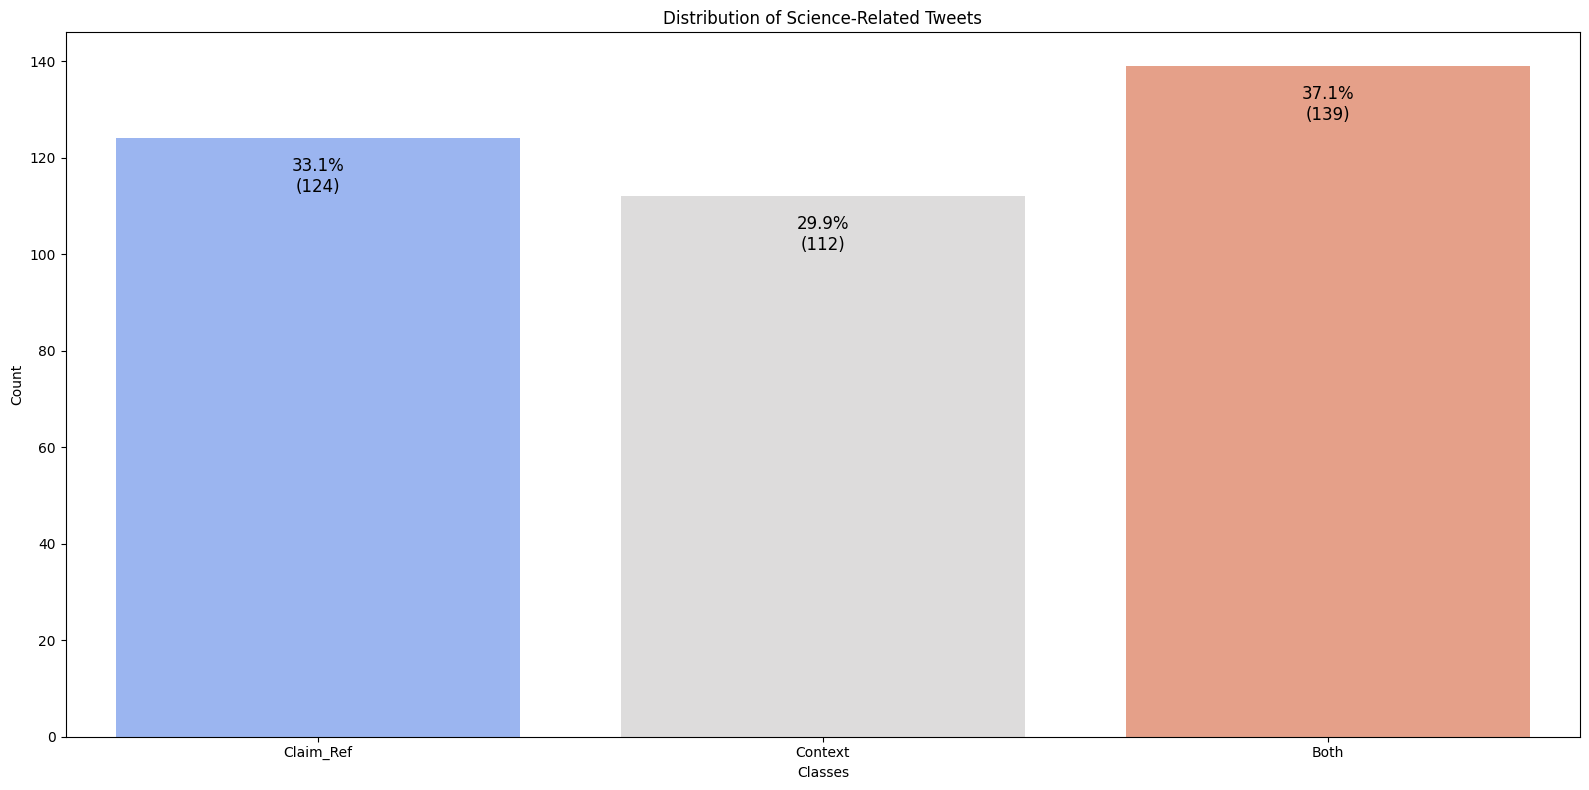

In [33]:
plt.figure(figsize=(16, 8))

ax = sns.countplot(x="classe", data=df, palette="coolwarm")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Claim_Ref", "Context", "Both"])

plt.title("Distribution of Science-Related Tweets")
plt.xlabel("Classes")
plt.ylabel("Count")

total = len(df)
class_counts = df["classe"].value_counts().sort_index()

for i, count in enumerate(class_counts):
    percentage = count / total * 100
    ax.text(i, count - 12, f"{percentage:.1f}%\n({count})", ha="center", va="bottom", fontsize=12,)


plt.tight_layout()
plt.show()

# Analyse des patterns linguistiques et structurels

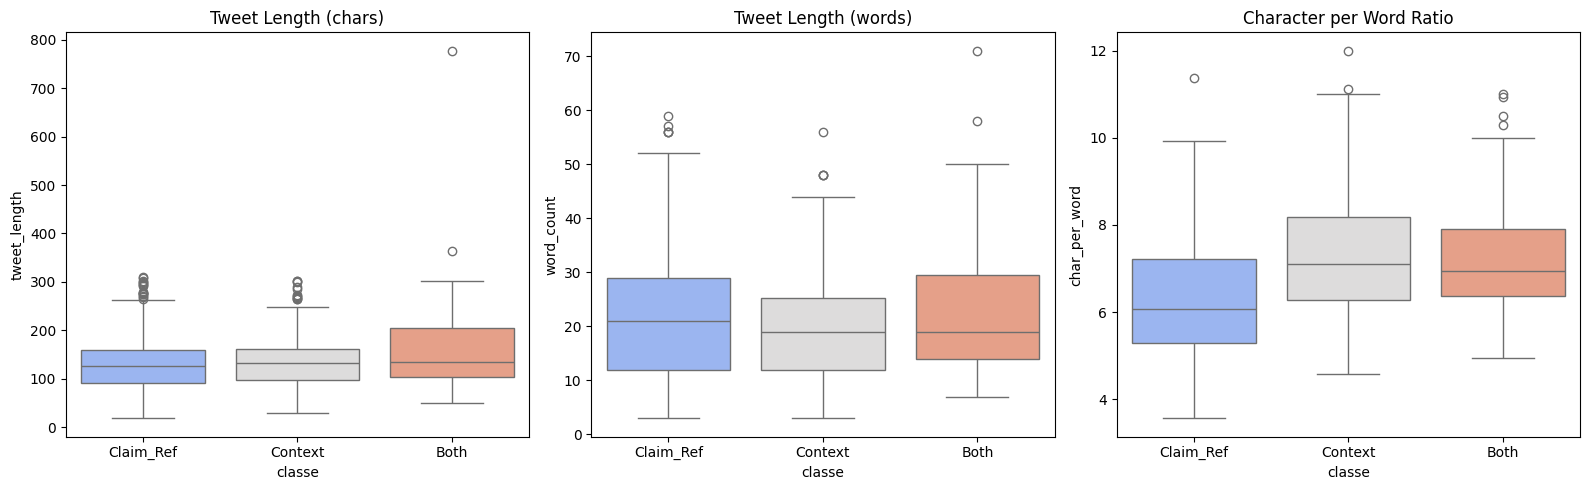

In [40]:
tokenizer = TweetTokenizer()

# Longueur en caractères
df["tweet_length"] = df["text"].apply(len)
# Nombre de mots
df["word_count"] = df["text"].apply(lambda x: len(tokenizer.tokenize(x)))
# Ratio caractères / mots
df["char_per_word"] = df["tweet_length"] / df["word_count"]

both_tweets = df[df["classe"] == 2]["tweet_length"]
context_tweets = df[df["classe"] == 1]["tweet_length"]
claim_ref_tweets = df[df["classe"] == 0]["tweet_length"]

plt.figure(figsize=(16, 5))

# 1. Longueur (caractères)
plt.subplot(1, 3, 1)
sns.boxplot(x="classe", y="tweet_length", data=df, palette="coolwarm")
plt.title("Tweet Length (chars)")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])
# 2. Nombre de mots
plt.subplot(1, 3, 2)
sns.boxplot(x="classe", y="word_count", data=df, palette="coolwarm")
plt.title("Tweet Length (words)")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])
# 3. Ratio char/mot
plt.subplot(1, 3, 3)
sns.boxplot(x="classe", y="char_per_word", data=df, palette="coolwarm")
plt.title("Character per Word Ratio")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])

plt.tight_layout()
plt.show()

Je me suis rendu compte que le ratio de lettre par mot peut être discriminants pour séparer claim ref de context / both

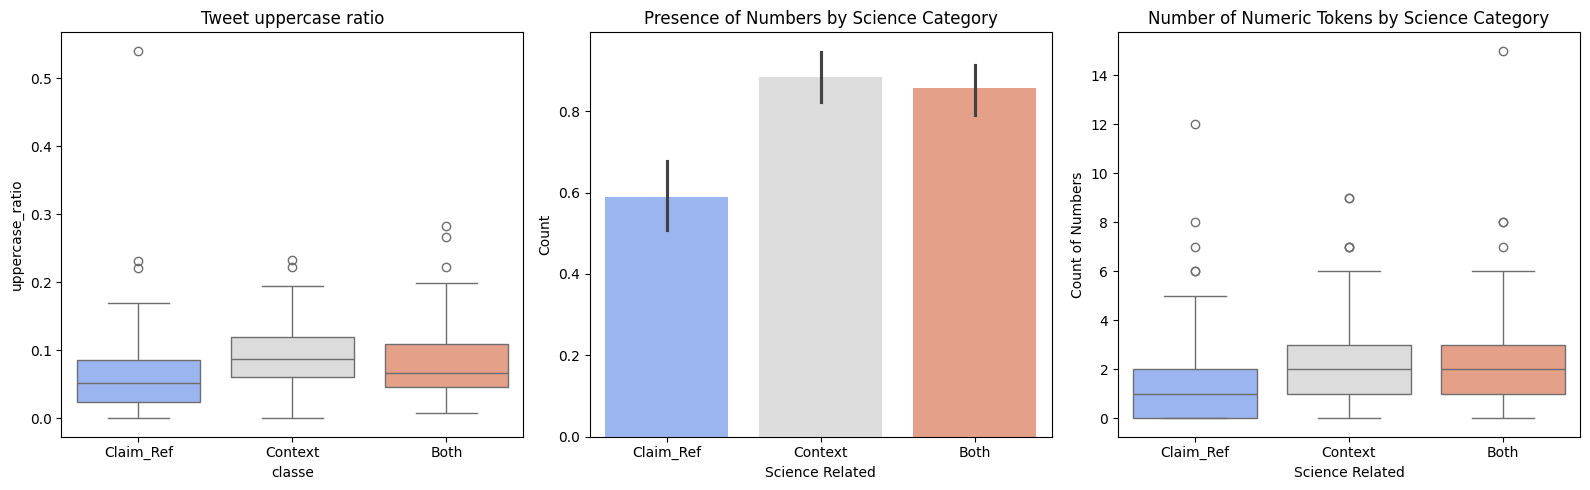

In [41]:
df["uppercase_ratio"] = df["text"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df["contains_numbers"] = df["text"].apply(lambda x: 1 if re.search(r'\d+', x) else 0)
df["numbers_count"] = df["text"].apply(lambda x: len(re.findall(r'\d+', x)))

plt.figure(figsize=(16, 5))

# 1. Ratio majuscule
plt.subplot(1, 3, 1)
sns.boxplot(x="classe", y="uppercase_ratio", data=df, palette="coolwarm")
plt.title("Tweet uppercase ratio")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])

# 2. contient des nombres
plt.subplot(1, 3, 2)
sns.barplot(x="classe", y="contains_numbers", data=df, palette="coolwarm")
plt.title("Presence of Numbers by Science Category")
plt.xlabel("Science Related")
plt.ylabel("Count")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])

plt.subplot(1, 3, 3)
sns.boxplot(x="classe", y="numbers_count", data=df, palette="coolwarm")
plt.title("Number of Numeric Tokens by Science Category")
plt.xlabel("Science Related")
plt.ylabel("Count of Numbers")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])
plt.tight_layout()

plt.show()

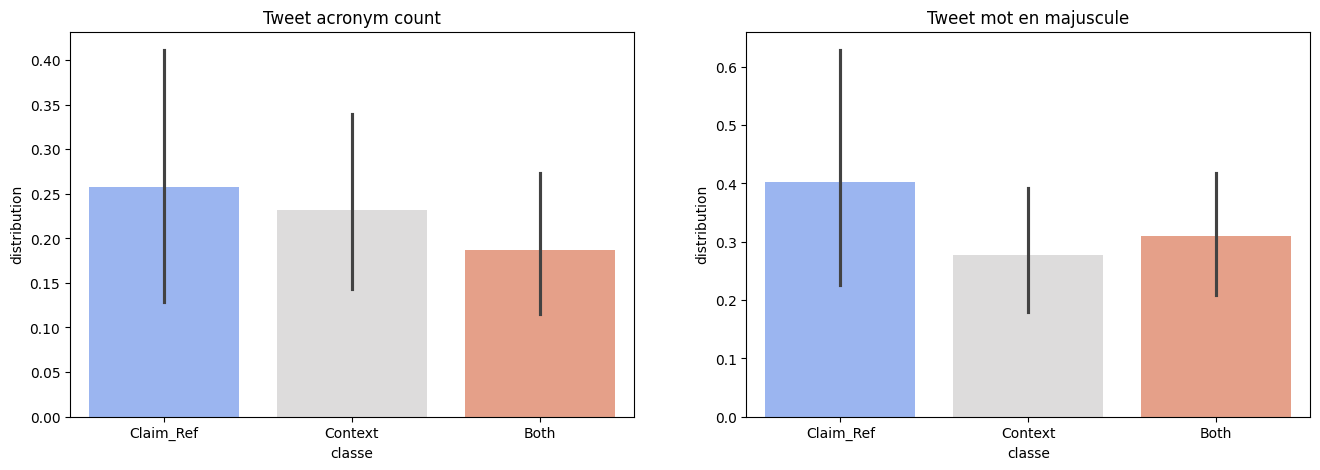

In [56]:
def count_acronyms(text):
    words = text.split()
    return sum(1 for word in words if word.isupper() and 2 <= len(word) <= 5 and word.isalpha())

def count_all_uppercase_words(text):
    words = text.split()
    return sum(1 for word in words if word.isupper() and word.isalpha())

df["acronym_count"] = df["text"].apply(count_acronyms)
df["all_uppercase_words"] = df["text"].apply(count_all_uppercase_words)

plt.figure(figsize=(16, 5))


plt.subplot(1, 2, 1)
sns.barplot(x="classe", y="acronym_count", data=df, palette="coolwarm")
plt.title("Tweet acronym count")
plt.ylabel("distribution")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])

plt.subplot(1, 2, 2)
sns.barplot(x="classe", y="all_uppercase_words", data=df, palette="coolwarm")
plt.ylabel("distribution")
plt.title("Tweet mot en majuscule")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])

plt.show()

In [92]:
group0 = df[df['classe'] == 0]['acronym_count']
group1 = df[df['classe'] == 1]['acronym_count']
group2 = df[df['classe'] == 2]['acronym_count']

stat, p = kruskal(group0, group1, group2)
print(f"Kruskal-Wallis H-test: stat={stat:.3f}, p-value={p:.4f}")

Kruskal-Wallis H-test: stat=0.811, p-value=0.6665


➤ Interprétation :
- Si p < 0.05 → il y a au moins une différence significative entre les classes.
- Si p ≥ 0.05 → l’effet est probablement du bruit.
  
p-value = 0.6665. p-value > .05  Donc acronym_count seul n'est pas discriminant

In [94]:
df[['acronym_count', 'uppercase_ratio', 'classe']].corr()

,acronym_count,uppercase_ratio,classe
acronym_count,1.000000,0.366976,-0.048630
uppercase_ratio,0.366976,1.000000,0.108094
classe,-0.048630,0.108094,1.000000


la corrélation entre est est de 0.37 ce qui veut dire qu'ils sont pas totalement indépendants, mais pas redondants non plus.
Je pense que la feature acronym_count ne sera pas utile...

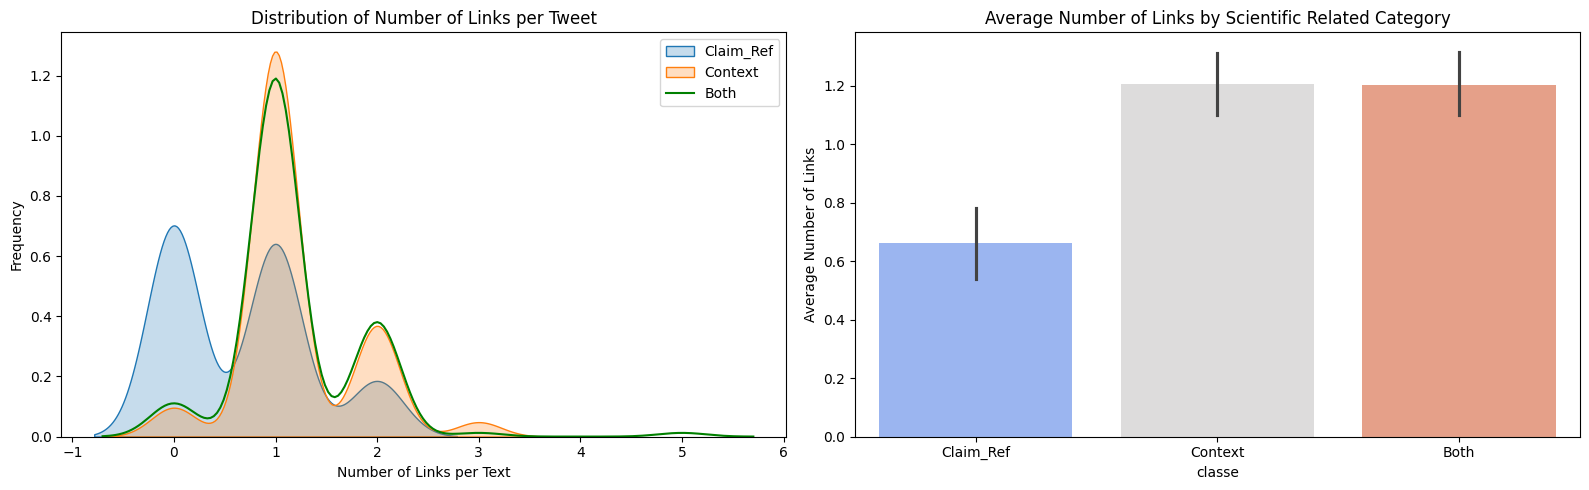

In [75]:
def count_links(text):
    """Counts the number of URLs in a text."""
    url_pattern = r'https?://\S+|www\.\S+'
    return len(re.findall(url_pattern, str(text)))

df["num_links"] = df["text"].apply(count_links)
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(df[df["classe"] == 0]["num_links"], label="Claim_Ref", shade=True)
sns.kdeplot(df[df["classe"] == 1]["num_links"], label="Context", shade=True)
sns.kdeplot(df[df["classe"] == 2]["num_links"], label="Both", color="green")
plt.legend()
plt.xlabel("Number of Links per Text")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Links per Tweet")

plt.subplot(1, 2, 2)
sns.barplot(x="classe", y="num_links", data=df, palette="coolwarm")
plt.title("Average Number of Links by Scientific Related Category")
plt.ylabel("Average Number of Links")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])

plt.tight_layout()
plt.show()


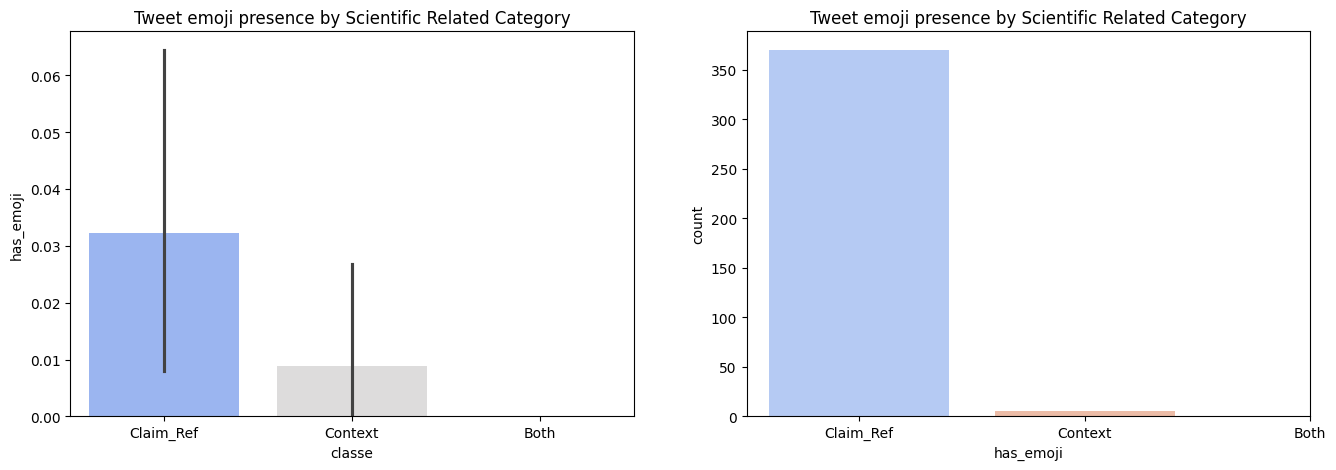

In [116]:
import emoji 
	
def count_emojis(text: str) -> int:
		return sum(1 for char in text if char in emoji.EMOJI_DATA)

def has_emoji(text):
    """Detects if a text contains at least one emoji."""
    return any(char in emoji.EMOJI_DATA for char in text)


df["has_emoji"] = df["text"].apply(has_emoji)
df["count_emoji"] = df["text"].apply(count_emojis)

plt.figure(figsize=(8 * 2 , 5))

plt.subplot(1, 2, 1)
sns.barplot(x="classe", y="has_emoji", data=df, palette="coolwarm")
plt.title("Tweet emoji presence by Scientific Related Category")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])

plt.subplot(1, 2, 2)
sns.countplot(x="has_emoji", data=df, palette="coolwarm")
plt.title("Tweet emoji presence by Scientific Related Category")
plt.xticks([0, 1, 2], ["Claim_Ref", "Context", "Both"])


plt.show()

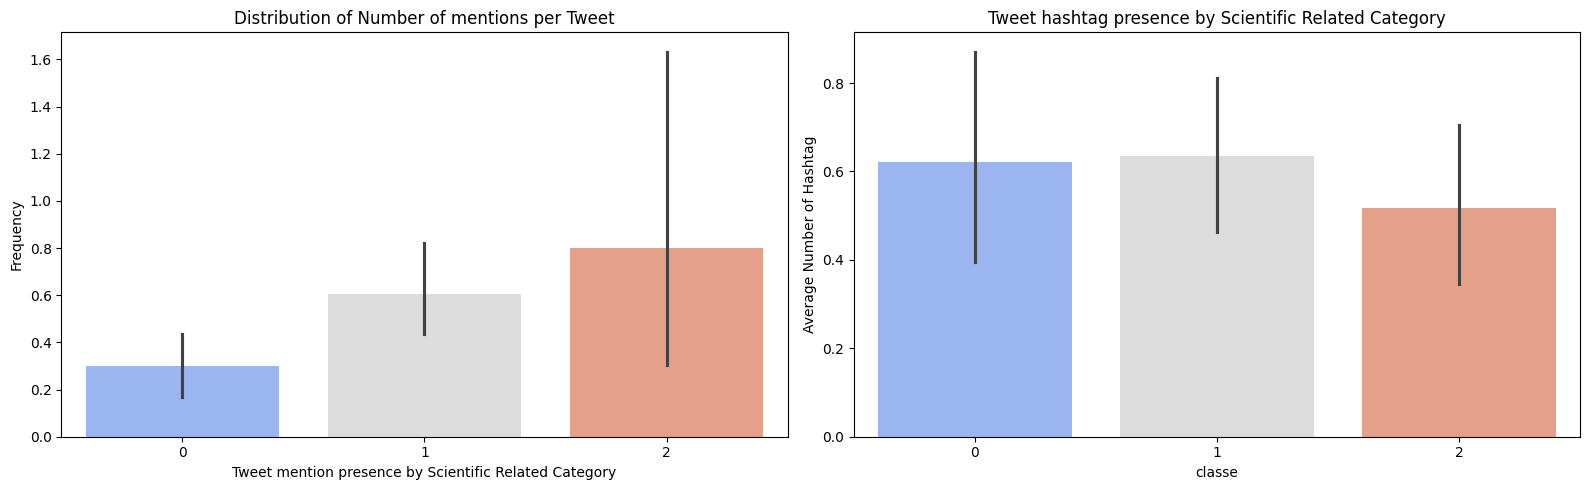

In [117]:
def mentions_number(text):
	"""Compute the number of tags by text ."""
	return len(re.findall(r'@[A-Za-z0-9_]+', text))

def hashtags_number(text):
	"""Compute the number of hashtags in the text."""
	return len(re.findall(r'#[A-Za-z0-9_]+', text))

df["mentions_number"] = df["text"].apply(mentions_number)
df["hashtags_number"] = df["text"].apply(hashtags_number)


plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.barplot(x="classe", y="mentions_number", data=df, palette="coolwarm")
plt.xlabel("Tweet mention presence by Scientific Related Category")
plt.ylabel("Frequency")
plt.title("Distribution of Number of mentions per Tweet")

plt.subplot(1, 2, 2)
sns.barplot(x="classe", y="hashtags_number", data=df, palette="coolwarm")
plt.title("Tweet hashtag presence by Scientific Related Category")
plt.ylabel("Average Number of Hashtag")

plt.tight_layout()
plt.show()

In [65]:
def hashtags(text):
	"""Extract hashtags from text."""
	return re.findall(r'#[A-Za-z0-9_]+', text)

claim_ref_hashtags = []
for text in df[df['classe'] == 0]['text']:
    claim_ref_hashtags.extend(hashtags(text))

context_hashtags = []
for text in df[df['classe'] == 1]['text']:
    context_hashtags.extend(hashtags(text))

both_hashtags = []
for text in df[df['classe'] == 2]['text']:
    both_hashtags.extend(hashtags(text))

claim_ref_hashtags_counts = Counter(claim_ref_hashtags)
context_hashtags_counts = Counter(context_hashtags)
both_hashtag_counts = Counter(both_hashtags)

top_claim_ref_hashtags = claim_ref_hashtags_counts.most_common(10)
top_context_hashtags = context_hashtags_counts.most_common(10)
top_both_hashtags = both_hashtag_counts.most_common(10)

<Figure size 1400x1000 with 0 Axes>

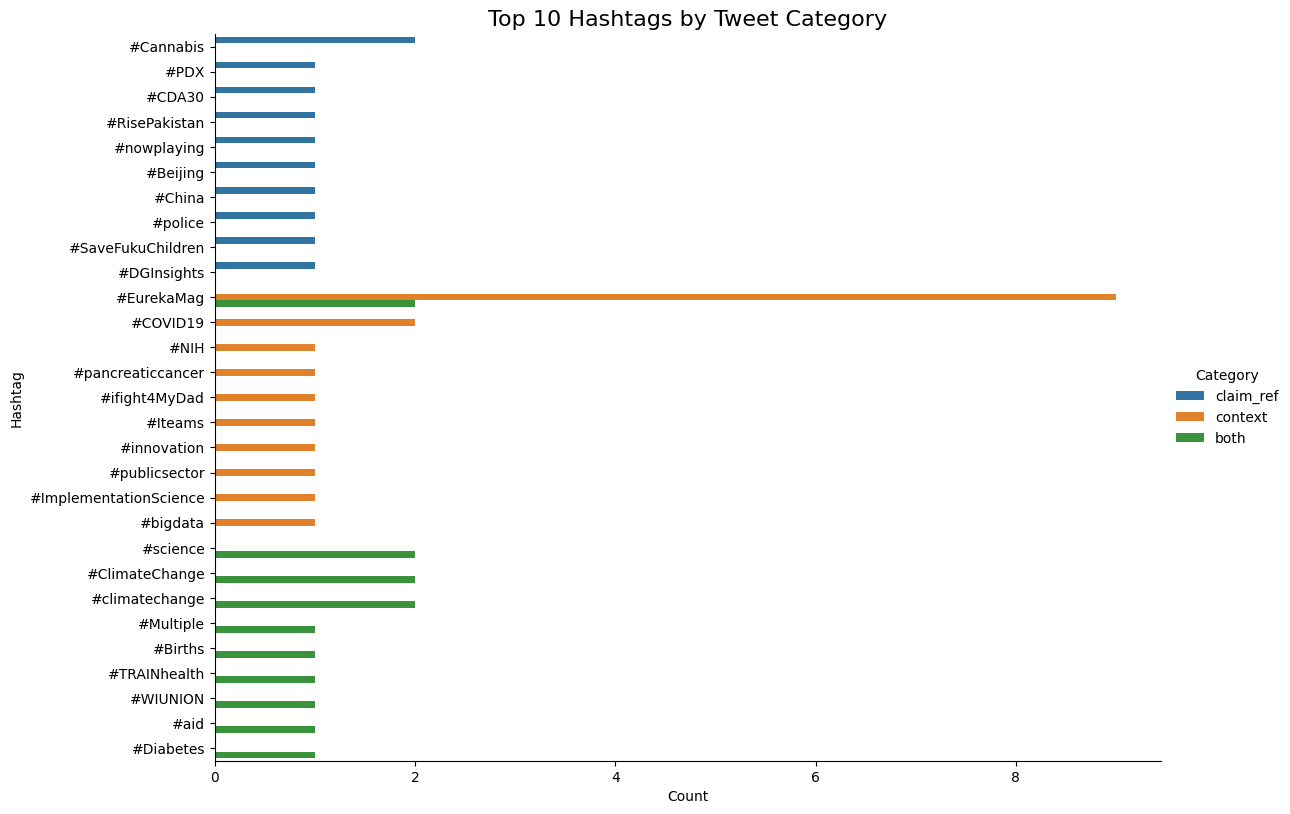

In [119]:
# Create DataFrames for plotting
claim_ref_df = pd.DataFrame(top_claim_ref_hashtags, columns=['Hashtag', 'Count'])
claim_ref_df['Category'] = 'claim_ref'

context_df = pd.DataFrame(top_context_hashtags, columns=['Hashtag', 'Count'])
context_df['Category'] = 'context'

both_df = pd.DataFrame(top_both_hashtags, columns=['Hashtag', 'Count'])
both_df['Category'] = 'both'

combined_df = pd.concat([claim_ref_df, context_df, both_df])

plt.figure(figsize=(14, 10))
sns.catplot(
    data=combined_df, 
    kind="bar",
    x="Count", y="Hashtag", hue="Category",
    height=8, aspect=1.5
)

plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.title('Top 10 Hashtags by Tweet Category', fontsize=16)
plt.show()

## Recherche de ces termes utiliser, en dehors d'un hastag

In [80]:
import re
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Assurez-vous d'avoir téléchargé les stopwords de NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Supprime les hashtags
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Supprime les liens
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha() and word not in stop_words]
    return words

# Création de deux listes : mots dans les tweets sci / non-sci
claim_red_words = []
context_words = []
both_words = []

for i, row in df.iterrows():
    words = clean_text(row['text'])
    if row['classe'] == 0:
        claim_red_words.extend(words)
    if row['classe'] == 1:
        context_words.extend(words)
    else:
        both_words.extend(words)

# Comptage des mots
claim_red_words_counts = Counter(claim_red_words)
context_word_counts = Counter(context_words)
both_word_counts = Counter(both_words)

# Top mots pour chaque catégorie
top_claim_red_words = claim_red_words_counts.most_common(10)
top_context_words = context_word_counts.most_common(10)
top_both_words = both_word_counts.most_common(10)


[nltk_data] Downloading package punkt to
[nltk_data]     /home/allan_dwyre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/allan_dwyre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 1400x1000 with 0 Axes>

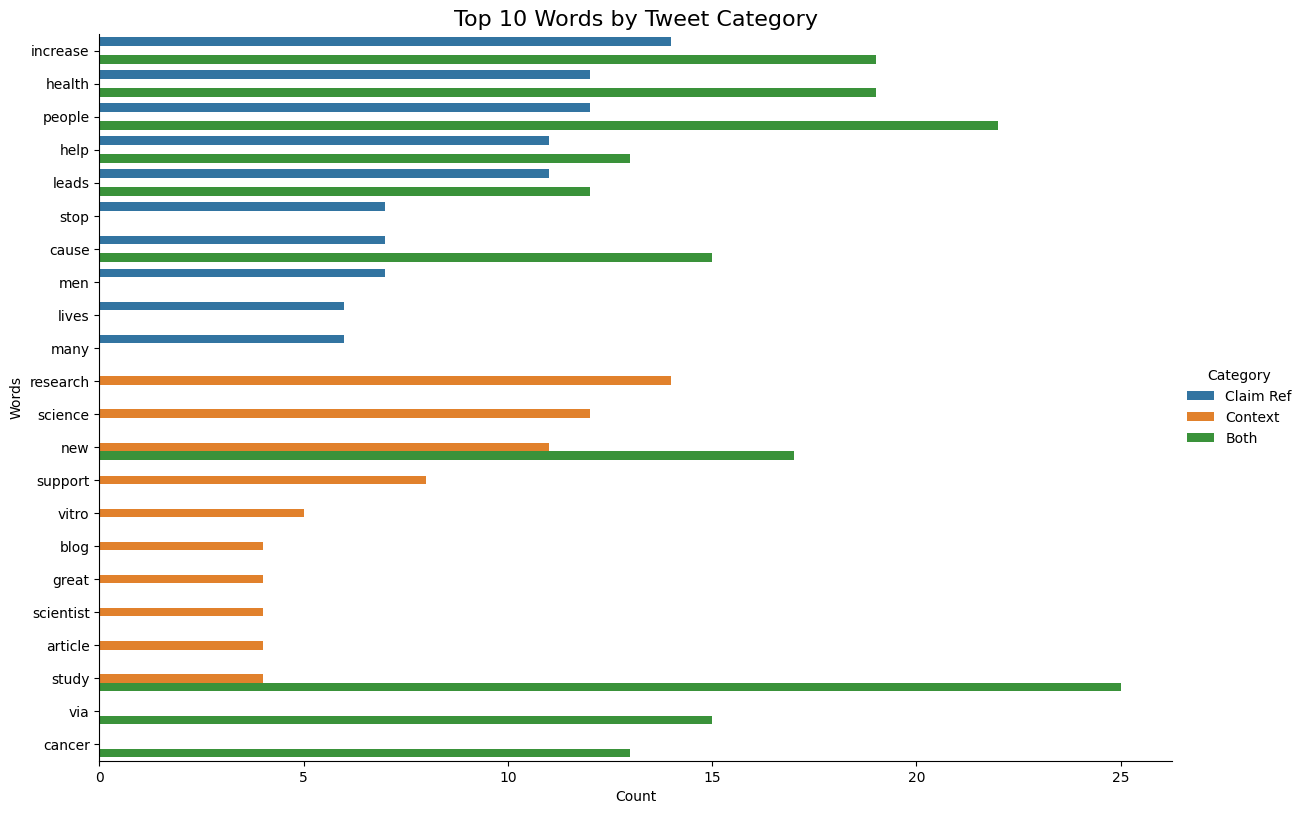

In [81]:
# Create DataFrames for plotting
claim_ref_df = pd.DataFrame(top_claim_red_words, columns=['Words', 'Count'])
claim_ref_df['Category'] = 'Claim Ref'

context_df = pd.DataFrame(top_context_words, columns=['Words', 'Count'])
context_df['Category'] = 'Context'

both_df = pd.DataFrame(top_both_words, columns=['Words', 'Count'])
both_df['Category'] = 'Both'

combined_df = pd.concat([claim_ref_df, context_df, both_df])

plt.figure(figsize=(14, 10))
sns.catplot(
    data=combined_df, 
    kind="bar",
    x="Count", y="Words", hue="Category",
    height=8, aspect=1.5
)

plt.xlabel("Count")
plt.ylabel("Words")
plt.title('Top 10 Words by Tweet Category', fontsize=16)
plt.show()

# Conclusion de l'analyse des trois classes : 


Nous avons vu ici, une forte différence de claim_ref envers context et both.
je pense qu'il n'y aura pas de souci à la distinction de claim ref.

Cependant, nous avons vu une subtilité entre context et both. En effet ces deux classes sont difficile a separer.

Cependant, cette subtilité existe, et je pense que j'arriverai a créer une classification.

De plus, si les resultats sont décevants, il sera facile de basculer vers une clasification binaire.

La vrai question, c'est comment gérer la quantité de donnée qui est trop faible pour le moment...